In [97]:
import numpy as np
from numpy import ndarray
import scipy as sc
import matplotlib.pyplot as plt
import math
from datetime import datetime
import random


noise_CR = 0.00
noise_AF = 0.00
bias_variance_CR = 0.02
bias_variance_AF = 0.02


class variant_probabilities:
    def __init__(self, mother_father_prob, fname_data_file, fname_truth_file, purity=1., n_segments=300, 
                 average_segment_length=1000, average_coverage=7, sd_average=0.005, sd_sd=0.005):
        """Inputs:
            - mother_father_prob is an array with 3 columns. The first shows the number of copies from the mother,
              the second shows the number of copies from the father and the third shows the frequency of this 
              configuration. Such as 
              mother_father_prob = [[0, 0, 0.00], 
                                    [0, 1, 0.10], 
                                    [1, 1, 0.70],
                                    [2, 0, 0.05],
                                    [2, 1, 0.04],
                                    [2, 2, 0.06],
                                    [3, 0, 0.02],
                                    [3, 1, 0.01],
                                    [3, 2, 0.00],
                                    [3, 3, 0.02]
                                   ]
            - fname_data_file: the output .seg file which will have the same format as that generated by ModeledSegment.
            - fname_truth_file: the truth data file containing the calls in its last column
            - purity: the purity of the cancer (purity=1: only cancer, purity=0: only normal)
            - n_segments: the number of segments that we generate
            - average_segment_lenght: average length of segments. The segment lengths are generated randomly from
              a Poisson distribution.
            - average_coverage: the average number of times a segment is covered by data 
            - sd_average: the deviation of the averages of the copy ratio distribution for a given segment
              is given by a Gaussian with standard deviation of "sd_average"
            - sd_sd: the 10th and 90th percentile's value is chosen such that they are a value 2*d away from the
                     50th percentile, where d is drawn from a Gaussian distribution with standard deviation sd_sd
        """ 
        
        
        
        
        # input data
        self.mother_father_prob = mother_father_prob
        self.purity = min(max(purity, 0), 1)
        self.n_segments = n_segments 
        self.average_segment_length = average_segment_length 
        self.average_coverage = average_coverage 
        self.sd_average = sd_average  
        self.sd_sd = sd_sd
        self.fname_data_file = fname_data_file 
        self.fname_truth_file = fname_truth_file 
        
        # data characterizing the copy ratio distribution
        self.copy_ratios_10th_perc = []
        self.copy_ratios_50th_perc = []
        self.copy_ratios_90th_perc = []
        
        # data characterizing the minor allele fraction distribution
        self.minor_allele_fractions_10th_perc = []
        self.minor_allele_fractions_50th_perc = []
        self.minor_allele_fractions_90th_perc = []
        
        # contig (which chromosome)
        self.contigs = []
        self.contig_lengths = []
        
        # truth data
        self.copy_numbers = []
        self.alleles_per_segment = []
        
        # segment lengths
        self.segment_lengths = []
        
        # Generate the data
        self.generate_random_data()
        
        # Create output file
        self.generate_data_file(self.fname_data_file)
        self.generate_truth_file(self.fname_truth_file)
        

    def generate_random_data(self):
        probs = [row[2] for row in self.mother_father_prob]
        total_prob = sum(probs)
        probs = [p / total_prob for p in probs]
        alleles = [row[0:2] for row in self.mother_father_prob]

        allele_choice_indices = np.random.choice(len(alleles), self.n_segments, p=probs)
        self.alleles_per_segment = [alleles[i] for i in allele_choice_indices]
        
        self.segment_lengths = np.random.poisson(self.average_segment_length, self.n_segments)
        coverages = [average_coverage] * self.n_segments
        
        self.copy_numbers = [(self.alleles_per_segment[i][0] + self.alleles_per_segment[i][1]) 
                             for i in range(self.n_segments)]
        self.copy_ratios = [(self.purity * (self.alleles_per_segment[i][0] + self.alleles_per_segment[i][1])
                            + (1 - self.purity) * 2) * coverages[i] 
                            for i in range(self.n_segments)]
        tot = sum(self.copy_ratios)
        self.copy_ratios = [c/tot*len(self.copy_ratios) for c in self.copy_ratios]
        self.minor_allele_fractions = [self.purity * min(al)/(al[0] + al[1]) + (1 - self.purity) * 0.5
                                       for al in self.alleles_per_segment]
        
        d_avg = np.random.normal(0, sd_average, self.n_segments)
        d_sd = np.random.normal(0, sd_sd, self.n_segments)
        d_sd = [abs(d) for d in d_sd]
        
        self.copy_ratios_50th_perc = [max(self.copy_ratios[i] + d_avg[i], 0.002) for i in range(self.n_segments)]
        self.copy_ratios_10th_perc = [max(self.copy_ratios_50th_perc[i] - 2*d_sd[i], 0.001) for i in range(self.n_segments)]
        self.copy_ratios_90th_perc = [max(self.copy_ratios_50th_perc[i] + 2*d_sd[i], 0.001) for i in range(self.n_segments)]
        
        d_avg = np.random.normal(0, sd_average, self.n_segments)
        d_sd = np.random.normal(0, sd_sd, self.n_segments)
        d_sd = [abs(d) for d in d_sd]
        
        self.minor_allele_fractions_50th_perc = [min(max(self.minor_allele_fractions[i] + d_avg[i], 0.002), 0.498) for i in range(self.n_segments)]
        self.minor_allele_fractions_10th_perc = [max(self.minor_allele_fractions_50th_perc[i] - 2*d_sd[i], 0.001) for i in range(self.n_segments)]
        self.minor_allele_fractions_90th_perc = [min(self.minor_allele_fractions_50th_perc[i] + 2*d_sd[i], 0.499) for i in range(self.n_segments)]
        
        self.contigs = [0] * self.n_segments
        approx_n_contigs = 23
        tmp_prob = approx_n_contigs/self.n_segments
        tmp = np.random.choice(2, self.n_segments, p=[1-tmp_prob, tmp_prob])
        current_contig = 1
        for i in range(self.n_segments):
            self.contigs[i] = current_contig
            current_contig = current_contig + tmp[i]
        
        xedges = np.linspace(0, 5, 100)
        yedges = np.linspace(0, 0.5, 100)
        fig=plt.figure(1, dpi=400)
        plt.hist2d(self.copy_ratios_50th_perc, self.minor_allele_fractions_50th_perc, bins=(xedges, yedges), cmap='gray_r')
        plt.colorbar()
        plt.xlabel("Copy ratio samples")
        plt.ylabel("Allele fraction samples")
        plt.title("Sampled data")
        plt.show()
        
        plt.hist(self.copy_ratios_50th_perc, bins=50)
        plt.xlabel("Copy ratio")
        plt.show()
        
        plt.hist(self.minor_allele_fractions_50th_perc, bins=50)
        plt.xlabel("Allele fraction")
        plt.show()
  

            
    def generate_file_header(self, is_truth:bool=True):
        text_header = "@HD\tVN:1.5\n"
        for i in range(len(self.contig_lengths)):
            text_header = text_header + "@SQ\tSN:" + str(i) + "\tLN:" + str(self.contig_lengths[i]) + "\n"
        
        if is_truth:
            text_header = text_header + ("@RG\tID:RANDOM_DATA_purity_{0}_n_segments={1}_average_segment_length={2}" 
                                         + "average_coverage={3}_sd_average={4}_sd_sd={5}\n".format(str(self.purity), 
                                                                                          str(self.n_segments), 
                                                                                          str(self.average_segment_length), 
                                                                                          str(self.average_coverage), 
                                                                                          str(self.sd_average), 
                                                                                          str(self.sd_sd))
                           )
            text_header = text_header + ("CONTIG\tSTART\tEND\tNUM_POINTS_COPY_RATIO\tNUM_POINTS_ALLELE_FRACTION" 
                                        + "\tLOG2_COPY_RATIO_POSTERIOR_10\tLOG2_COPY_RATIO_POSTERIOR_50"
                                        + "\tLOG2_COPY_RATIO_POSTERIOR_90\tMINOR_ALLELE_FRACTION_POSTERIOR_10"
                                        + "\tMINOR_ALLELE_FRACTION_POSTERIOR_50\tMINOR_ALLELE_FRACTION_POSTERIOR_90"
                                        + "\tCALL\tPHRED\n")
        else:
            text_header = text_header + ("@RG\tID:RANDOM_TRUTH_purity={0}_n_segments={1}_average_segment_length={2}" 
                                         + "_average_coverage={3}_sd_average={4}_sd_sd={5}\n".format(str(self.purity), 
                                                                                          str(self.n_segments), 
                                                                                          str(self.average_segment_length), 
                                                                                          str(self.average_coverage), 
                                                                                          str(self.sd_average), 
                                                                                          str(self.sd_sd))
                           )
            text_header = text_header + ("CONTIG\tSTART\tEND\tNUM_POINTS_COPY_RATIO\tNUM_POINTS_ALLELE_FRACTION" 
                                        + "\tLOG2_COPY_RATIO_POSTERIOR_10\tLOG2_COPY_RATIO_POSTERIOR_50"
                                        + "\tLOG2_COPY_RATIO_POSTERIOR_90\tMINOR_ALLELE_FRACTION_POSTERIOR_10"
                                        + "\tMINOR_ALLELE_FRACTION_POSTERIOR_50\tMINOR_ALLELE_FRACTION_POSTERIOR_90\n")
        return text_header
    
    def generate_data_file(self, fname_data_file):
        file_body = ""
        genomic_location = 1
        contig_old = self.contigs[0]
        for i in range(self.n_segments):
            if contig_old != self.contigs[i]:
                self.contig_lengths.append(genomic_location + random.randint(1, 100))
                genomic_location = 1
            file_body = file_body + ("{0}\t{1}\t{2}\t{3}\t{4}\t{5:.8f}\t{6:.8f}\t{7:.8f}\t{8:.8f}\t{9:.8f}\t{10:.8f}\n".format(
                self.contigs[i],
                genomic_location,
                genomic_location + self.segment_lengths[i],
                int(round(np.random.uniform(low=0.4*self.segment_lengths[i], high=self.segment_lengths[i]))),
                int(round(np.random.uniform(low=0.4*self.segment_lengths[i], high=self.segment_lengths[i]))),
                math.log(self.copy_ratios_10th_perc[i], 2),
                math.log(self.copy_ratios_50th_perc[i], 2),
                math.log(self.copy_ratios_90th_perc[i], 2),
                self.minor_allele_fractions_10th_perc[i],
                self.minor_allele_fractions_50th_perc[i],
                self.minor_allele_fractions_90th_perc[i]
            ))
            genomic_location = genomic_location + self.segment_lengths[i] + random.randint(1,100)
            contig_old = self.contigs[i]
        
        file_header = self.generate_file_header(is_truth=False)
        text_file = open(self.fname_data_file, "w")
        text_file.write(file_header)
        text_file.write(file_body)
        text_file.close()
        
    def generate_truth_file(self, fname_truth_file):
        file_body = ""
        genomic_location = 1
        contig_old = self.contigs[0]
        for i in range(self.n_segments):
            if contig_old != self.contigs[i]:
                self.contig_lengths.append(genomic_location + random.randint(1, 100))
                genomic_location = 1

            if self.alleles_per_segment[i][0] == 1 and self.alleles_per_segment[i][1] == 1:
                del_ampl_char = '0'
                phred = 100
            elif self.copy_numbers[i] == 2:
                del_ampl_char = '/'
                phred = 0
            elif self.copy_numbers[i] < 2:
                del_ampl_char = '-'
                phred = 0
            elif self.copy_numbers[i] > 2:
                del_ampl_char = '+'
                phred = 0
            else:
                del_ampl_char = '?'
                phred = float('nan')
                
            if purity == 0:
                del_ampl_char = '0'
                phred = 100                
            
            file_body = file_body + ("{0}\t{1}\t{2}\t{3}\t{4}\t{5:.8f}\t{6:.8f}\t{7:.8f}\t{8:.8f}\t{9:.8f}\t{10:.8f}\t{11}\t{12}\n".format(
                self.contigs[i],
                genomic_location,
                genomic_location + self.segment_lengths[i],
                int(round(np.random.uniform(low=0.4*self.segment_lengths[i], high=self.segment_lengths[i]))),
                int(round(np.random.uniform(low=0.4*self.segment_lengths[i], high=self.segment_lengths[i]))),
                math.log(self.copy_ratios_10th_perc[i], 2),
                math.log(self.copy_ratios_50th_perc[i], 2),
                math.log(self.copy_ratios_90th_perc[i], 2),
                self.minor_allele_fractions_10th_perc[i],
                self.minor_allele_fractions_50th_perc[i],
                self.minor_allele_fractions_90th_perc[i],
                del_ampl_char,
                phred
            ))
            genomic_location = genomic_location + self.segment_lengths[i] + random.randint(1,100)
            contig_old = self.contigs[i]
        
        file_header = self.generate_file_header(is_truth=True)
        text_file = open(self.fname_truth_file, "w")
        text_file.write(file_header)
        text_file.write(file_body)
        text_file.close()


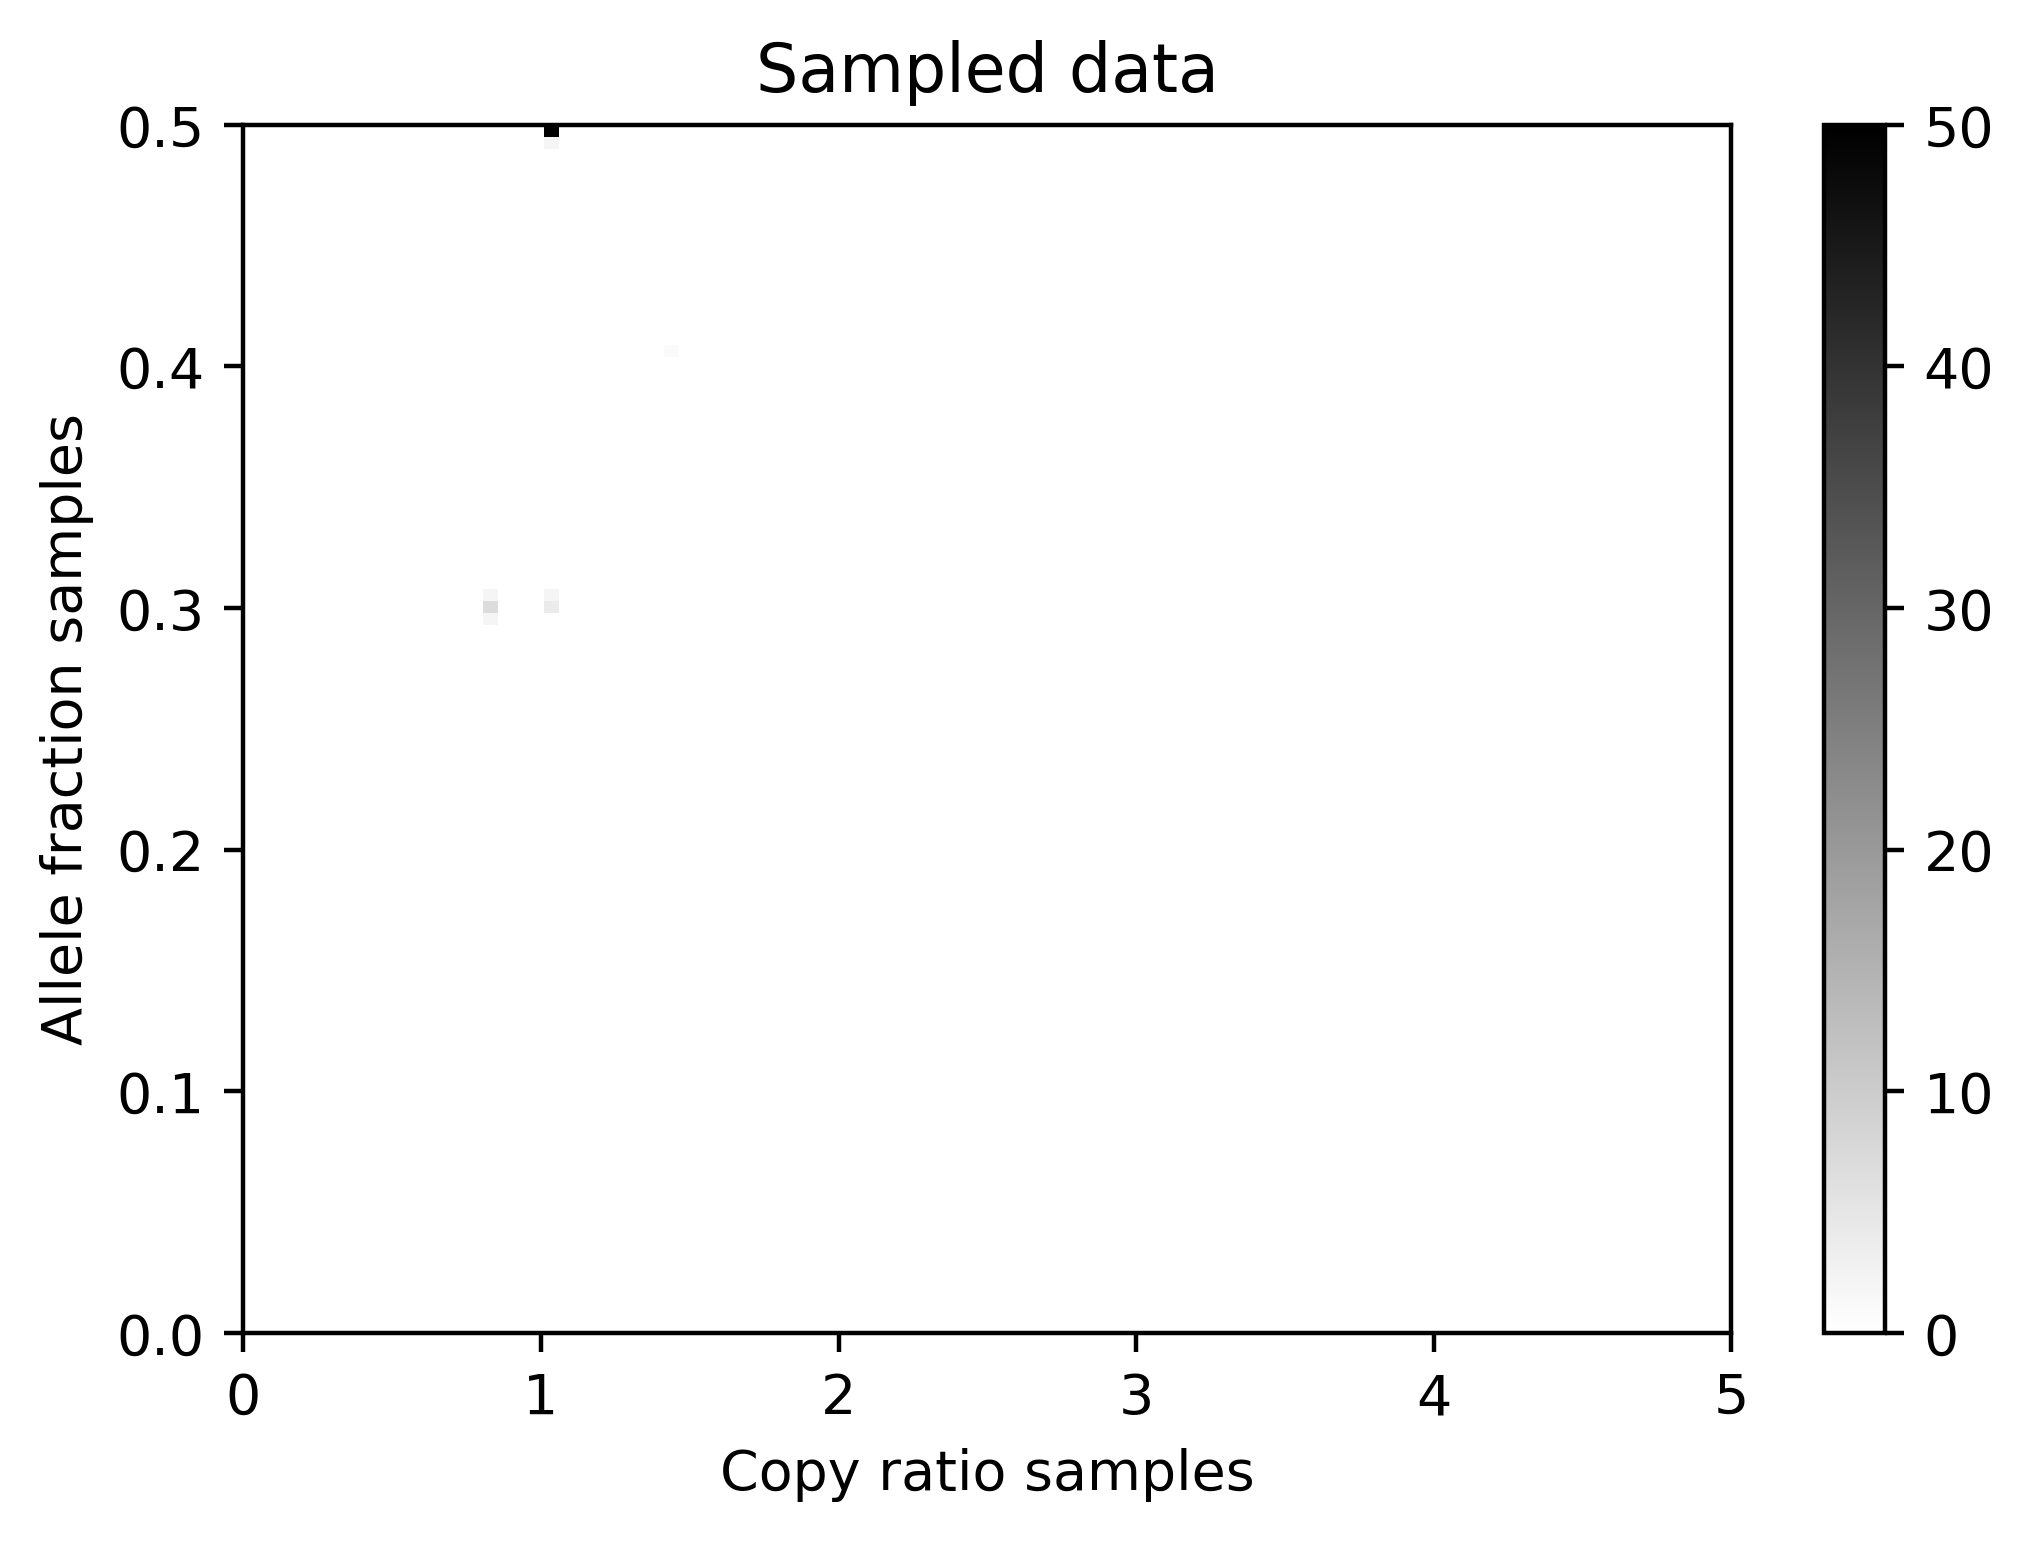

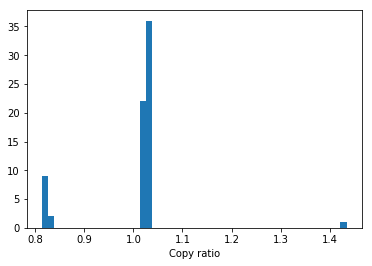

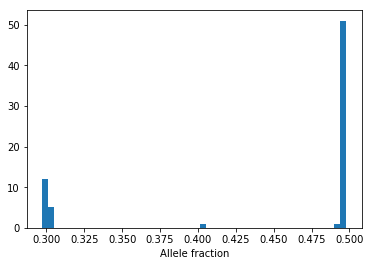

In [98]:
fname_data_file = "/Users/mkanaszn/Desktop/testing/cancer_0p40_purity_data.seg" 
fname_truth_file = "/Users/mkanaszn/Desktop/testing/cancer_0p40_purity_truth.seg" 

purity=0.4
mother_father_prob = [[0, 0, 0.00], 
                      [0, 1, 0.20], 
                      [1, 1, 0.70],
                      [2, 0, 0.05],
                      [2, 1, 0.00],
                      [2, 2, 0.00],
                      [3, 0, 0.02],
                      [3, 1, 0.01],
                      [3, 2, 0.00],
                      [3, 3, 0.02]
                      ]

n_segments=70
average_segment_length=10000
average_coverage=7

sd_average=0.003
sd_sd=0.003


v = variant_probabilities(fname_data_file=fname_data_file,
                         fname_truth_file=fname_truth_file,
                         mother_father_prob=mother_father_prob,
                         purity=purity,
                         n_segments=n_segments,
                         average_segment_length=average_segment_length,
                         average_coverage=average_coverage,
                         sd_average=sd_average,
                         sd_sd = sd_sd
                         )

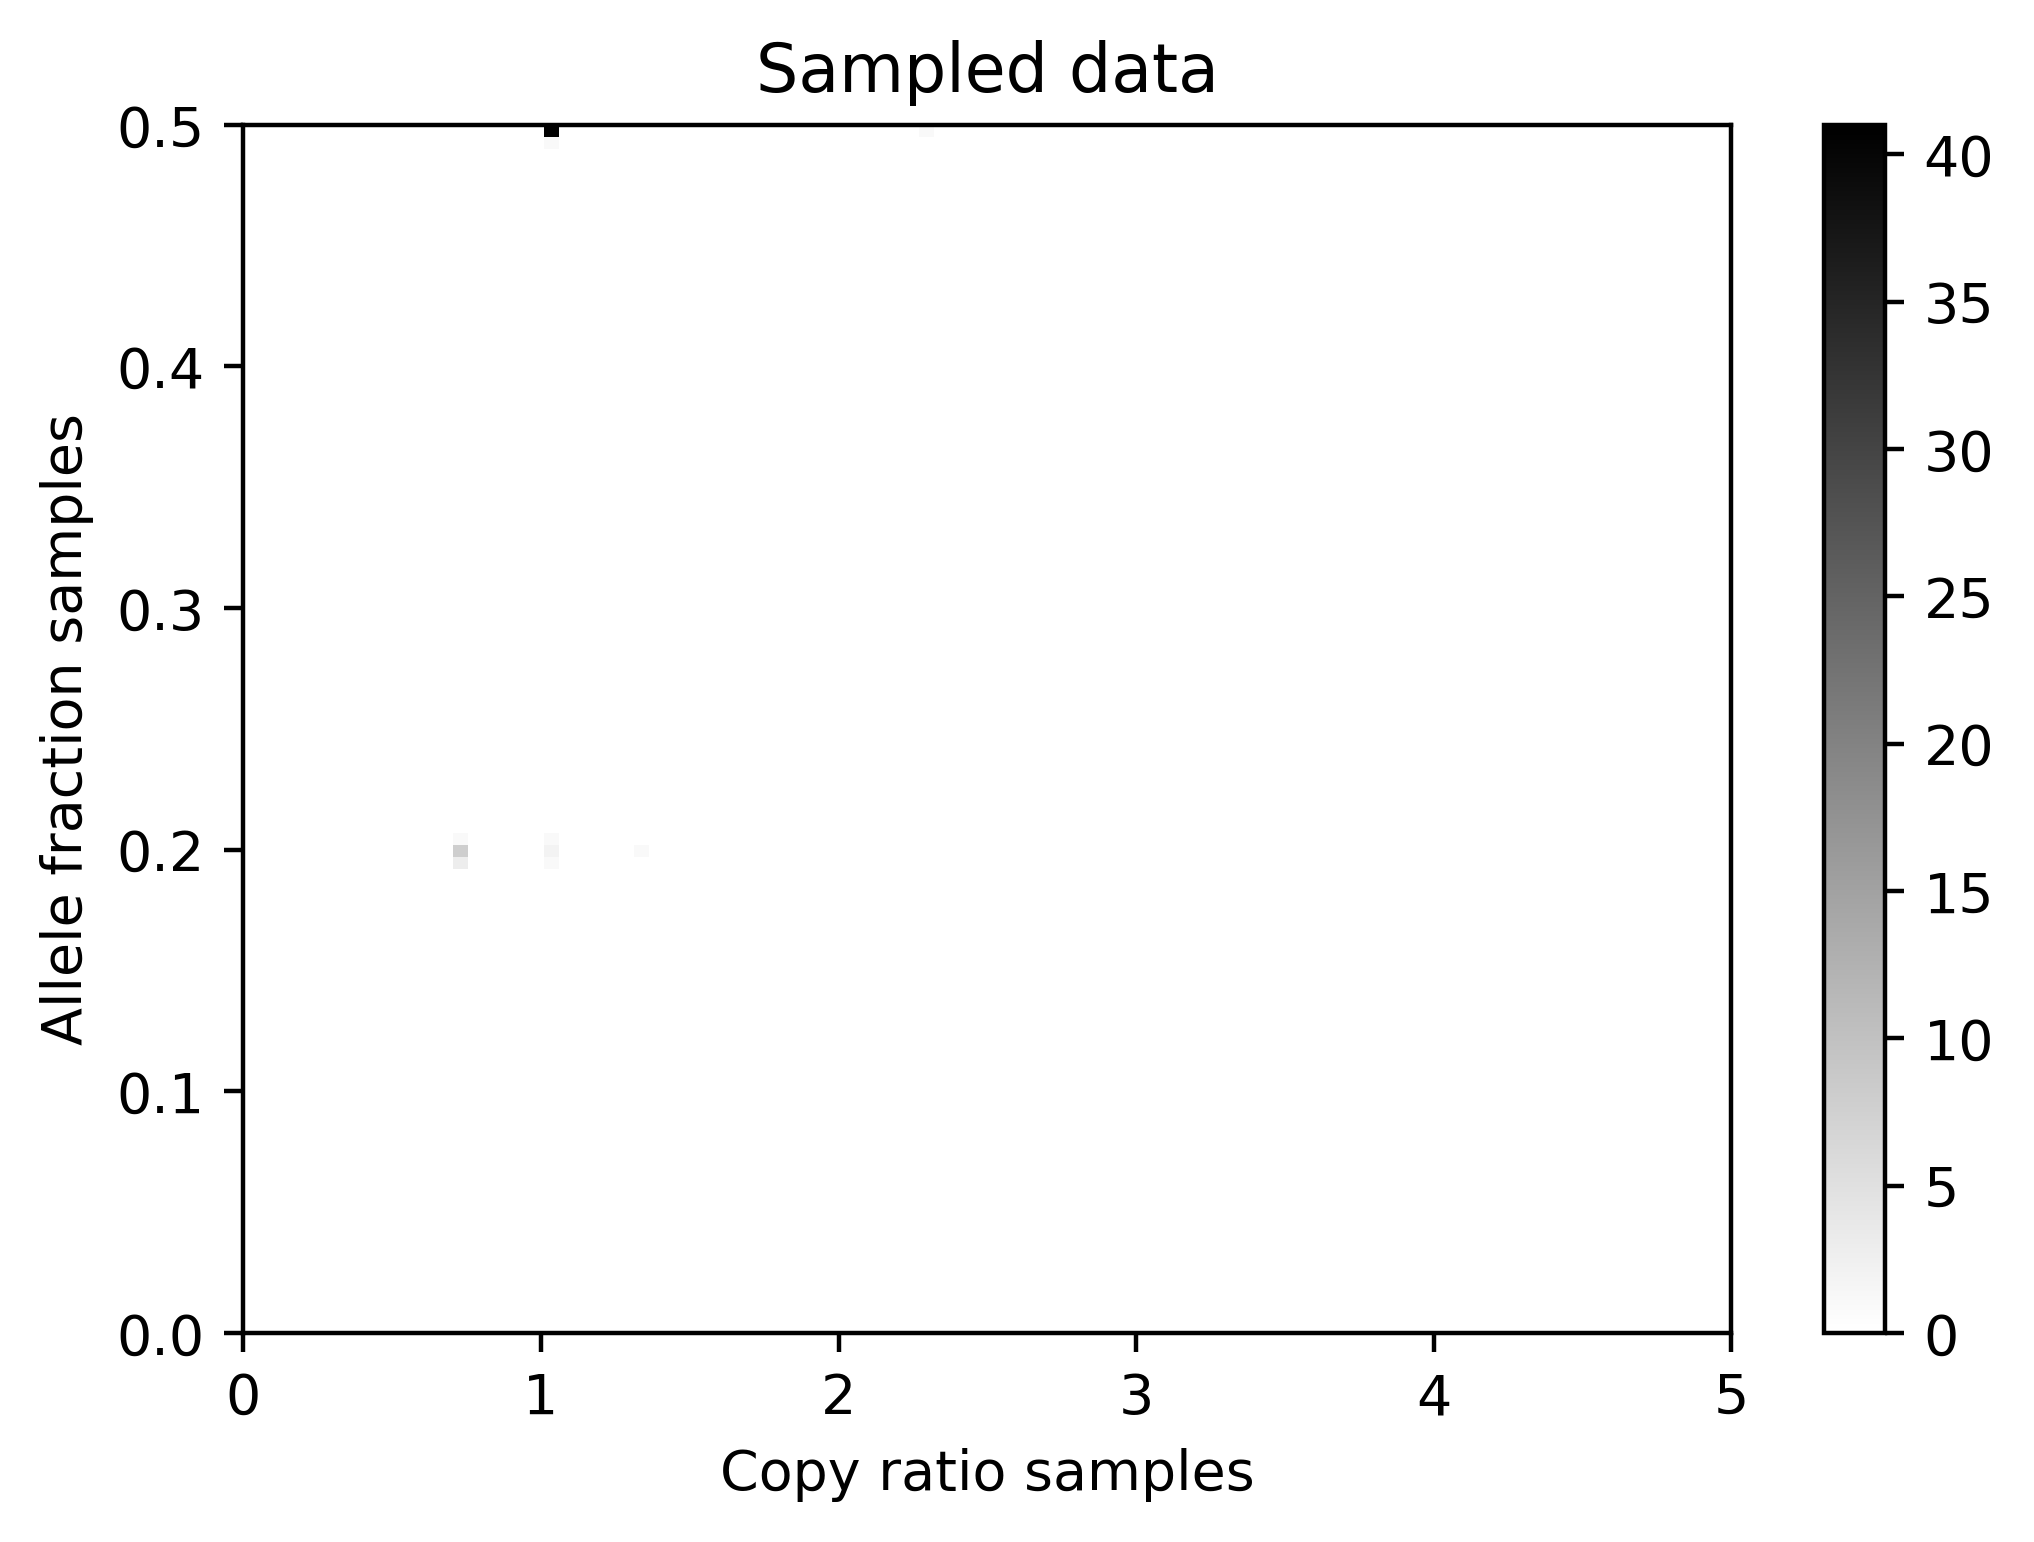

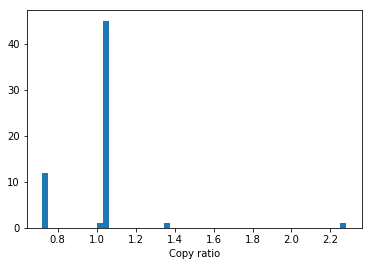

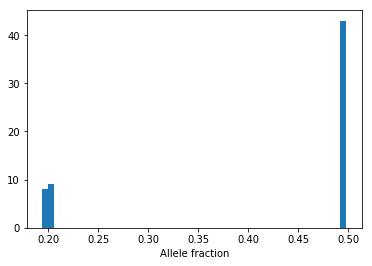

In [99]:
fname_data_file = "/Users/mkanaszn/Desktop/testing/cancer_0p60_purity_data.seg" 
fname_truth_file = "/Users/mkanaszn/Desktop/testing/cancer_0p60_purity_truth.seg" 

purity=0.6
mother_father_prob = [[0, 0, 0.00], 
                      [0, 1, 0.20], 
                      [1, 1, 0.70],
                      [2, 0, 0.05],
                      [2, 1, 0.00],
                      [2, 2, 0.00],
                      [3, 0, 0.02],
                      [3, 1, 0.01],
                      [3, 2, 0.00],
                      [3, 3, 0.02]
                      ]

n_segments=60
average_segment_length=10000
average_coverage=7

sd_average=0.003
sd_sd=0.008


v = variant_probabilities(fname_data_file=fname_data_file,
                         fname_truth_file=fname_truth_file,
                         mother_father_prob=mother_father_prob,
                         purity=purity,
                         n_segments=n_segments,
                         average_segment_length=average_segment_length,
                         average_coverage=average_coverage,
                         sd_average=sd_average,
                         sd_sd = sd_sd
                         )

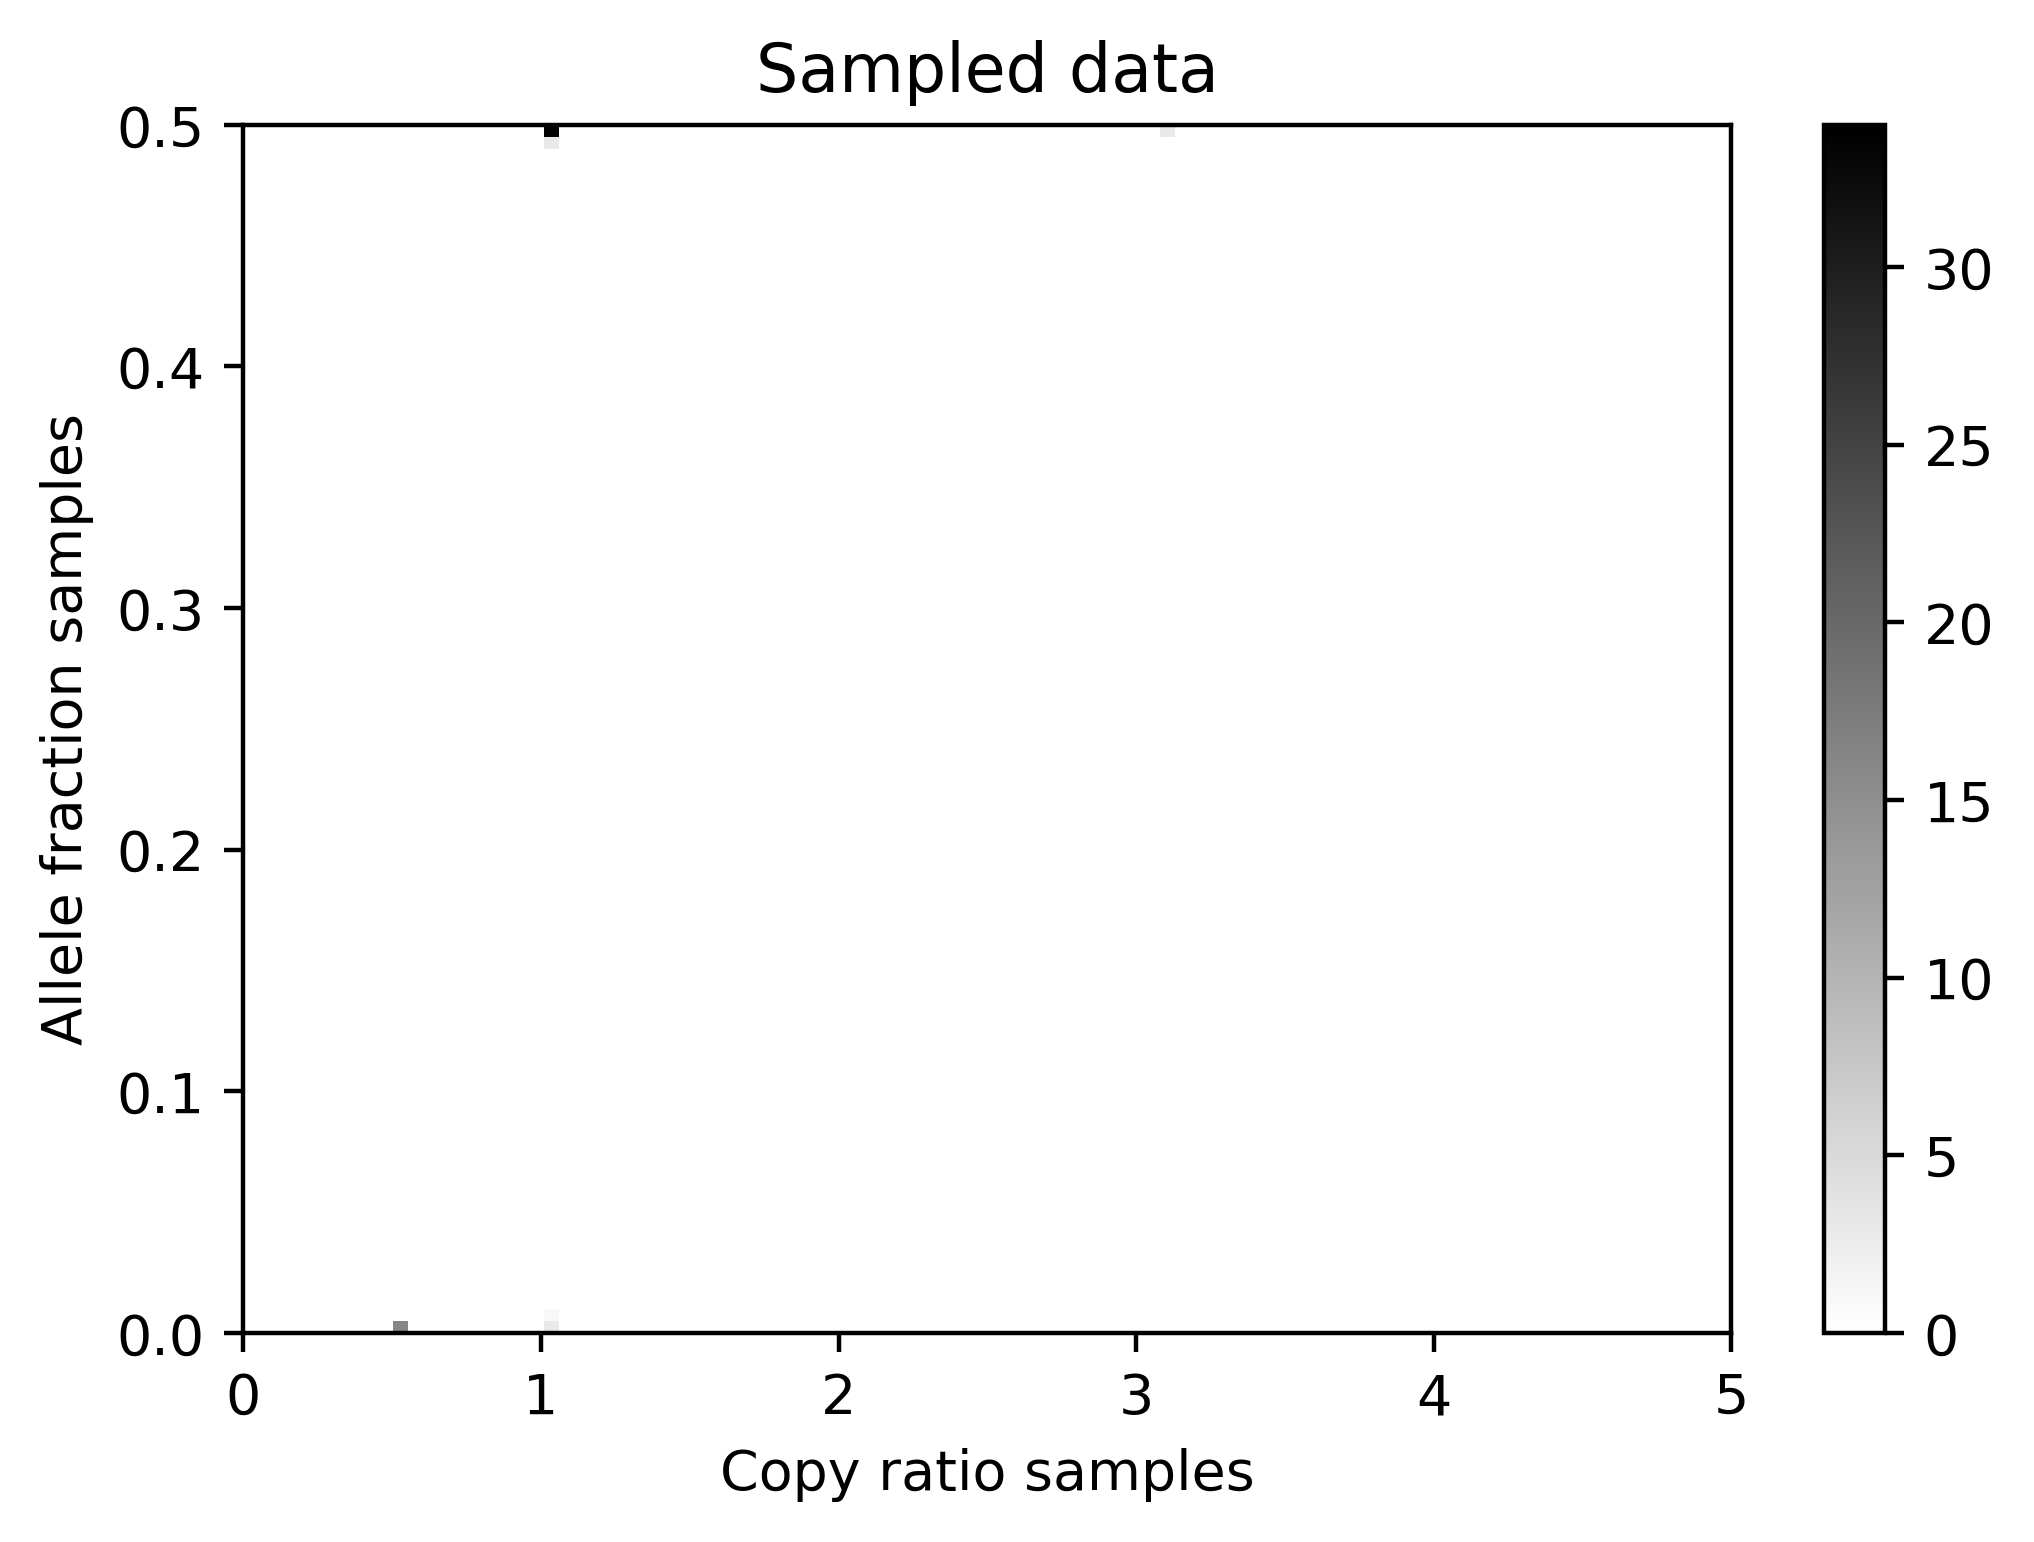

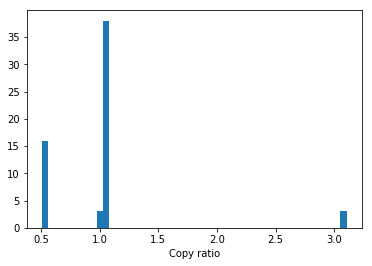

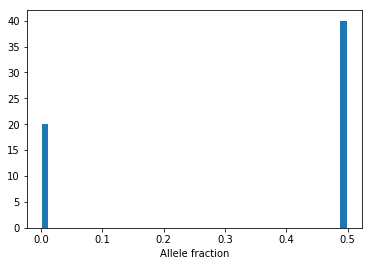

In [100]:
fname_data_file = "/Users/mkanaszn/Desktop/testing/cancer_1p00_purity_data.seg" 
fname_truth_file = "/Users/mkanaszn/Desktop/testing/cancer_1p00_purity_truth.seg" 

purity=1.0
mother_father_prob = [[0, 0, 0.00], 
                      [0, 1, 0.20], 
                      [1, 1, 0.70],
                      [2, 0, 0.05],
                      [2, 1, 0.00],
                      [2, 2, 0.00],
                      [3, 0, 0.02],
                      [3, 1, 0.01],
                      [3, 2, 0.00],
                      [3, 3, 0.02]
                      ]

n_segments=60
average_segment_length=10000
average_coverage=7

sd_average=0.003
sd_sd=0.008


v = variant_probabilities(fname_data_file=fname_data_file,
                         fname_truth_file=fname_truth_file,
                         mother_father_prob=mother_father_prob,
                         purity=purity,
                         n_segments=n_segments,
                         average_segment_length=average_segment_length,
                         average_coverage=average_coverage,
                         sd_average=sd_average,
                         sd_sd = sd_sd
                         )

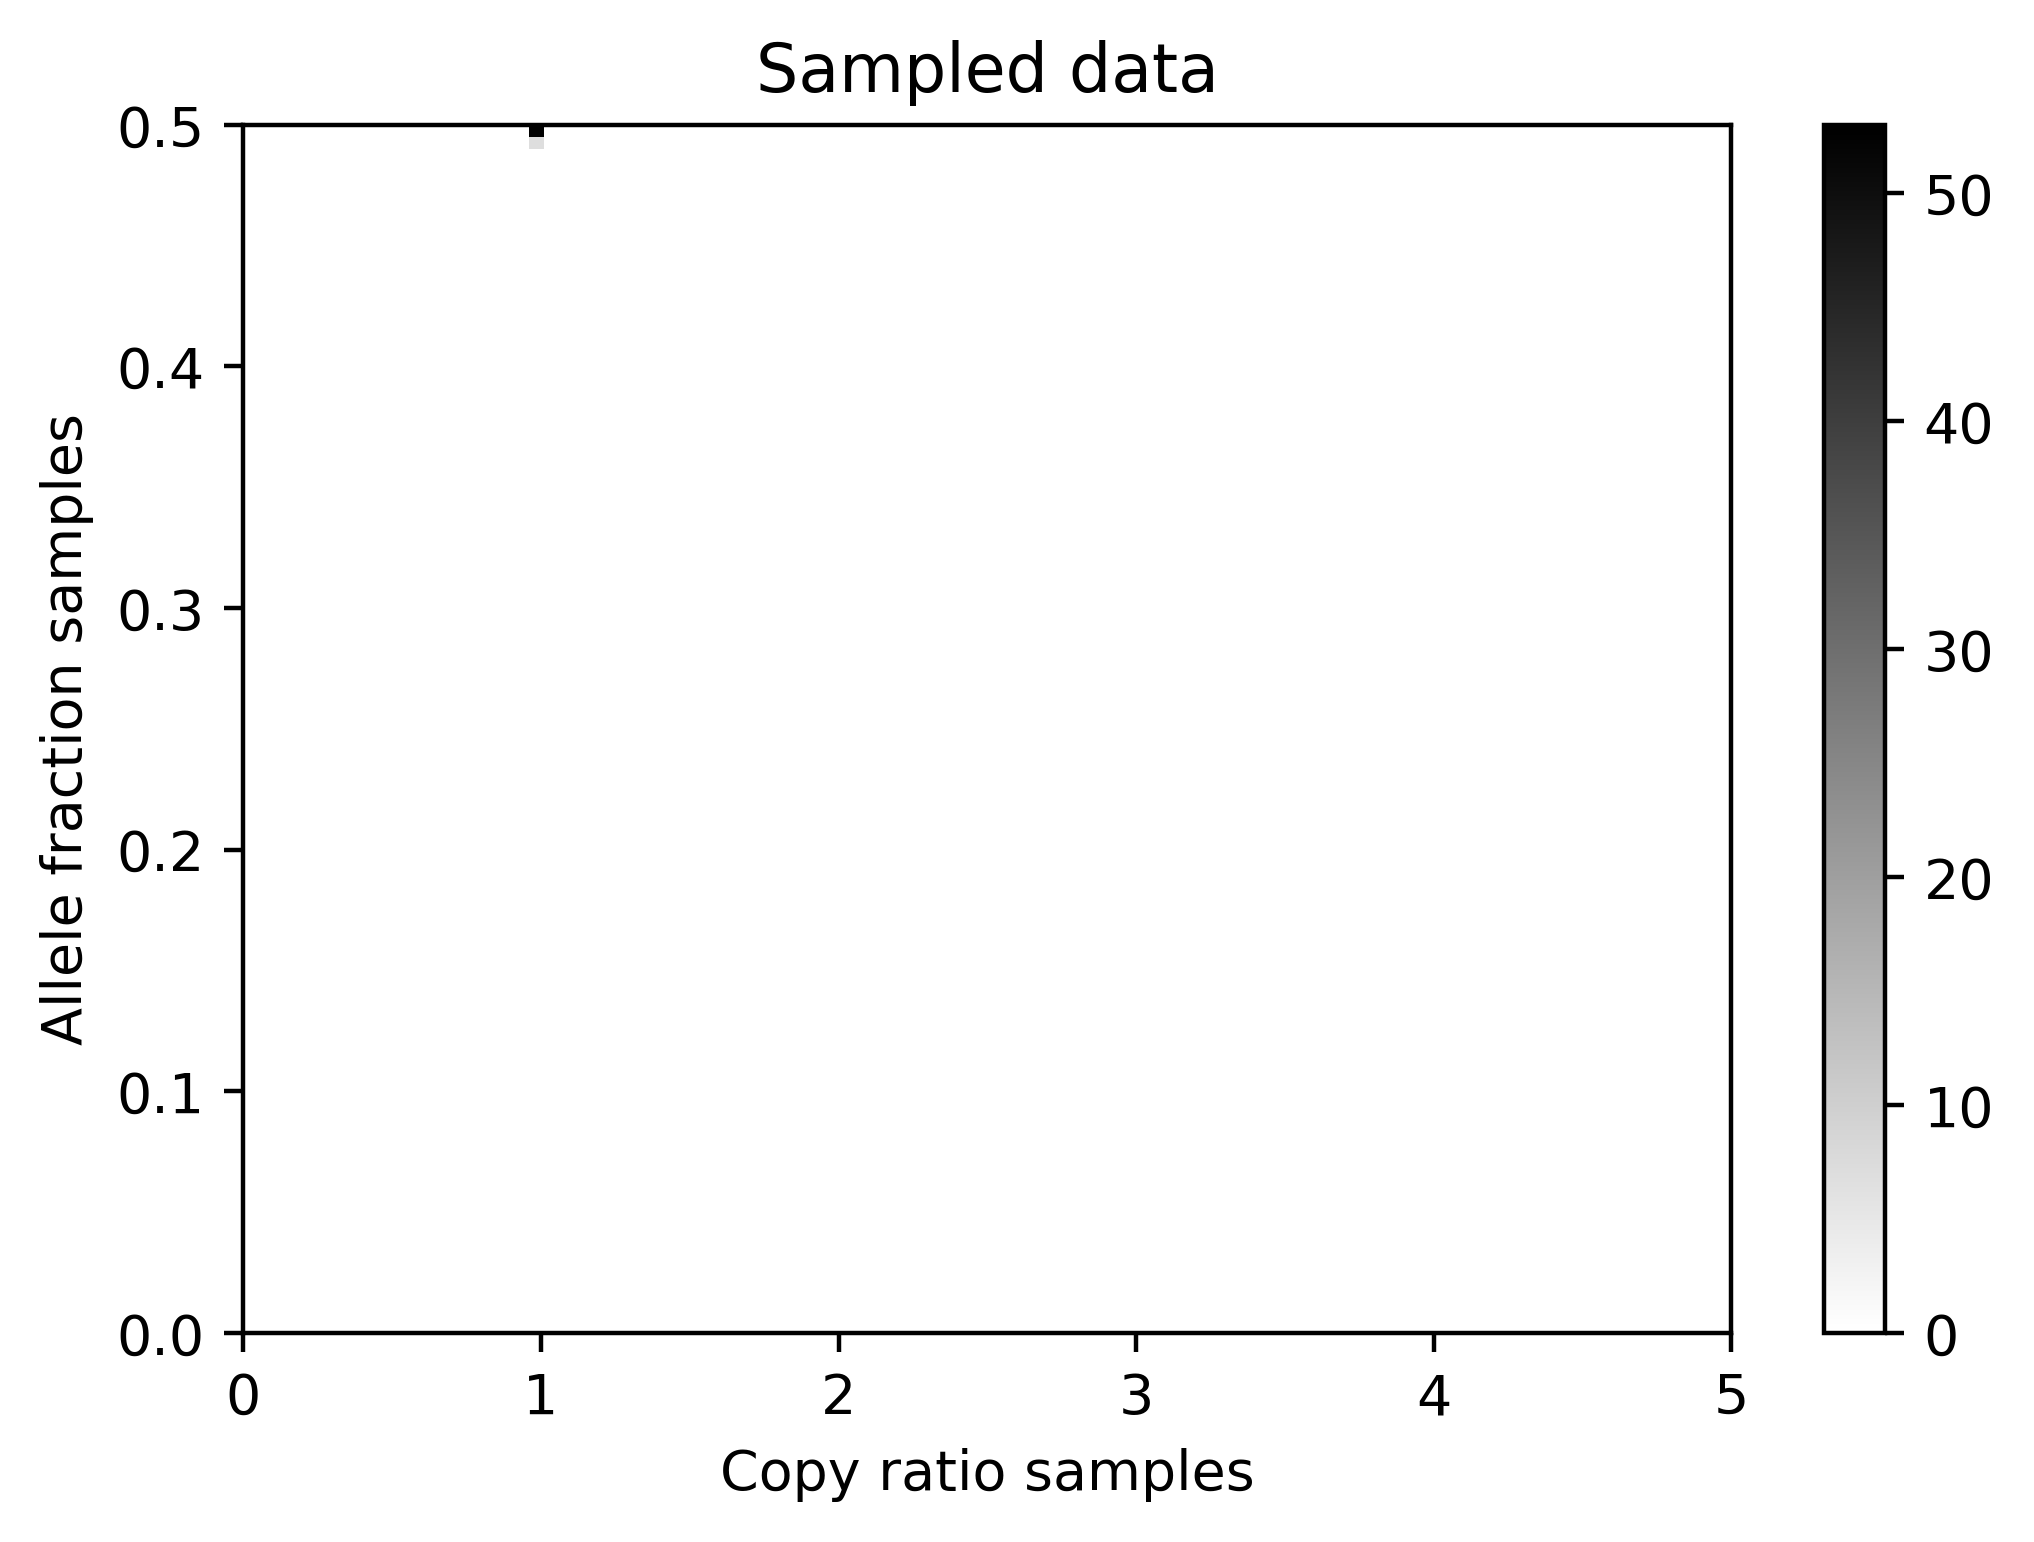

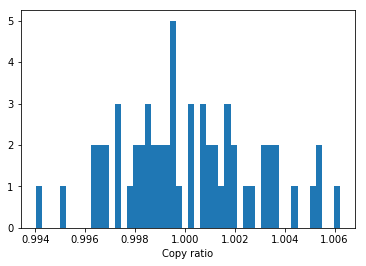

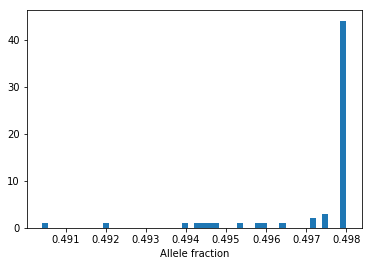

In [101]:
fname_data_file = "/Users/mkanaszn/Desktop/testing/normal_sample_data.seg" 
fname_truth_file = "/Users/mkanaszn/Desktop/testing/normal_sample_truth.seg"

purity=1.0
mother_father_prob = [[0, 0, 0], 
                      [0, 1, 0], 
                      [1, 1, 1],
                      [2, 0, 0],
                      [2, 1, 0],
                      [2, 2, 0],
                      [3, 0, 0],
                      [3, 1, 0],
                      [3, 2, 0],
                      [3, 3, 0]
                      ]

n_segments=60
average_segment_length=10000
average_coverage=7

sd_average=0.003
sd_sd=0.008

v = variant_probabilities(fname_data_file=fname_data_file,
                         fname_truth_file=fname_truth_file,
                         mother_father_prob=mother_father_prob,
                         purity=purity,
                         n_segments=n_segments,
                         average_segment_length=average_segment_length,
                         average_coverage=average_coverage,
                         sd_average=sd_average,
                         sd_sd = sd_sd
                         )

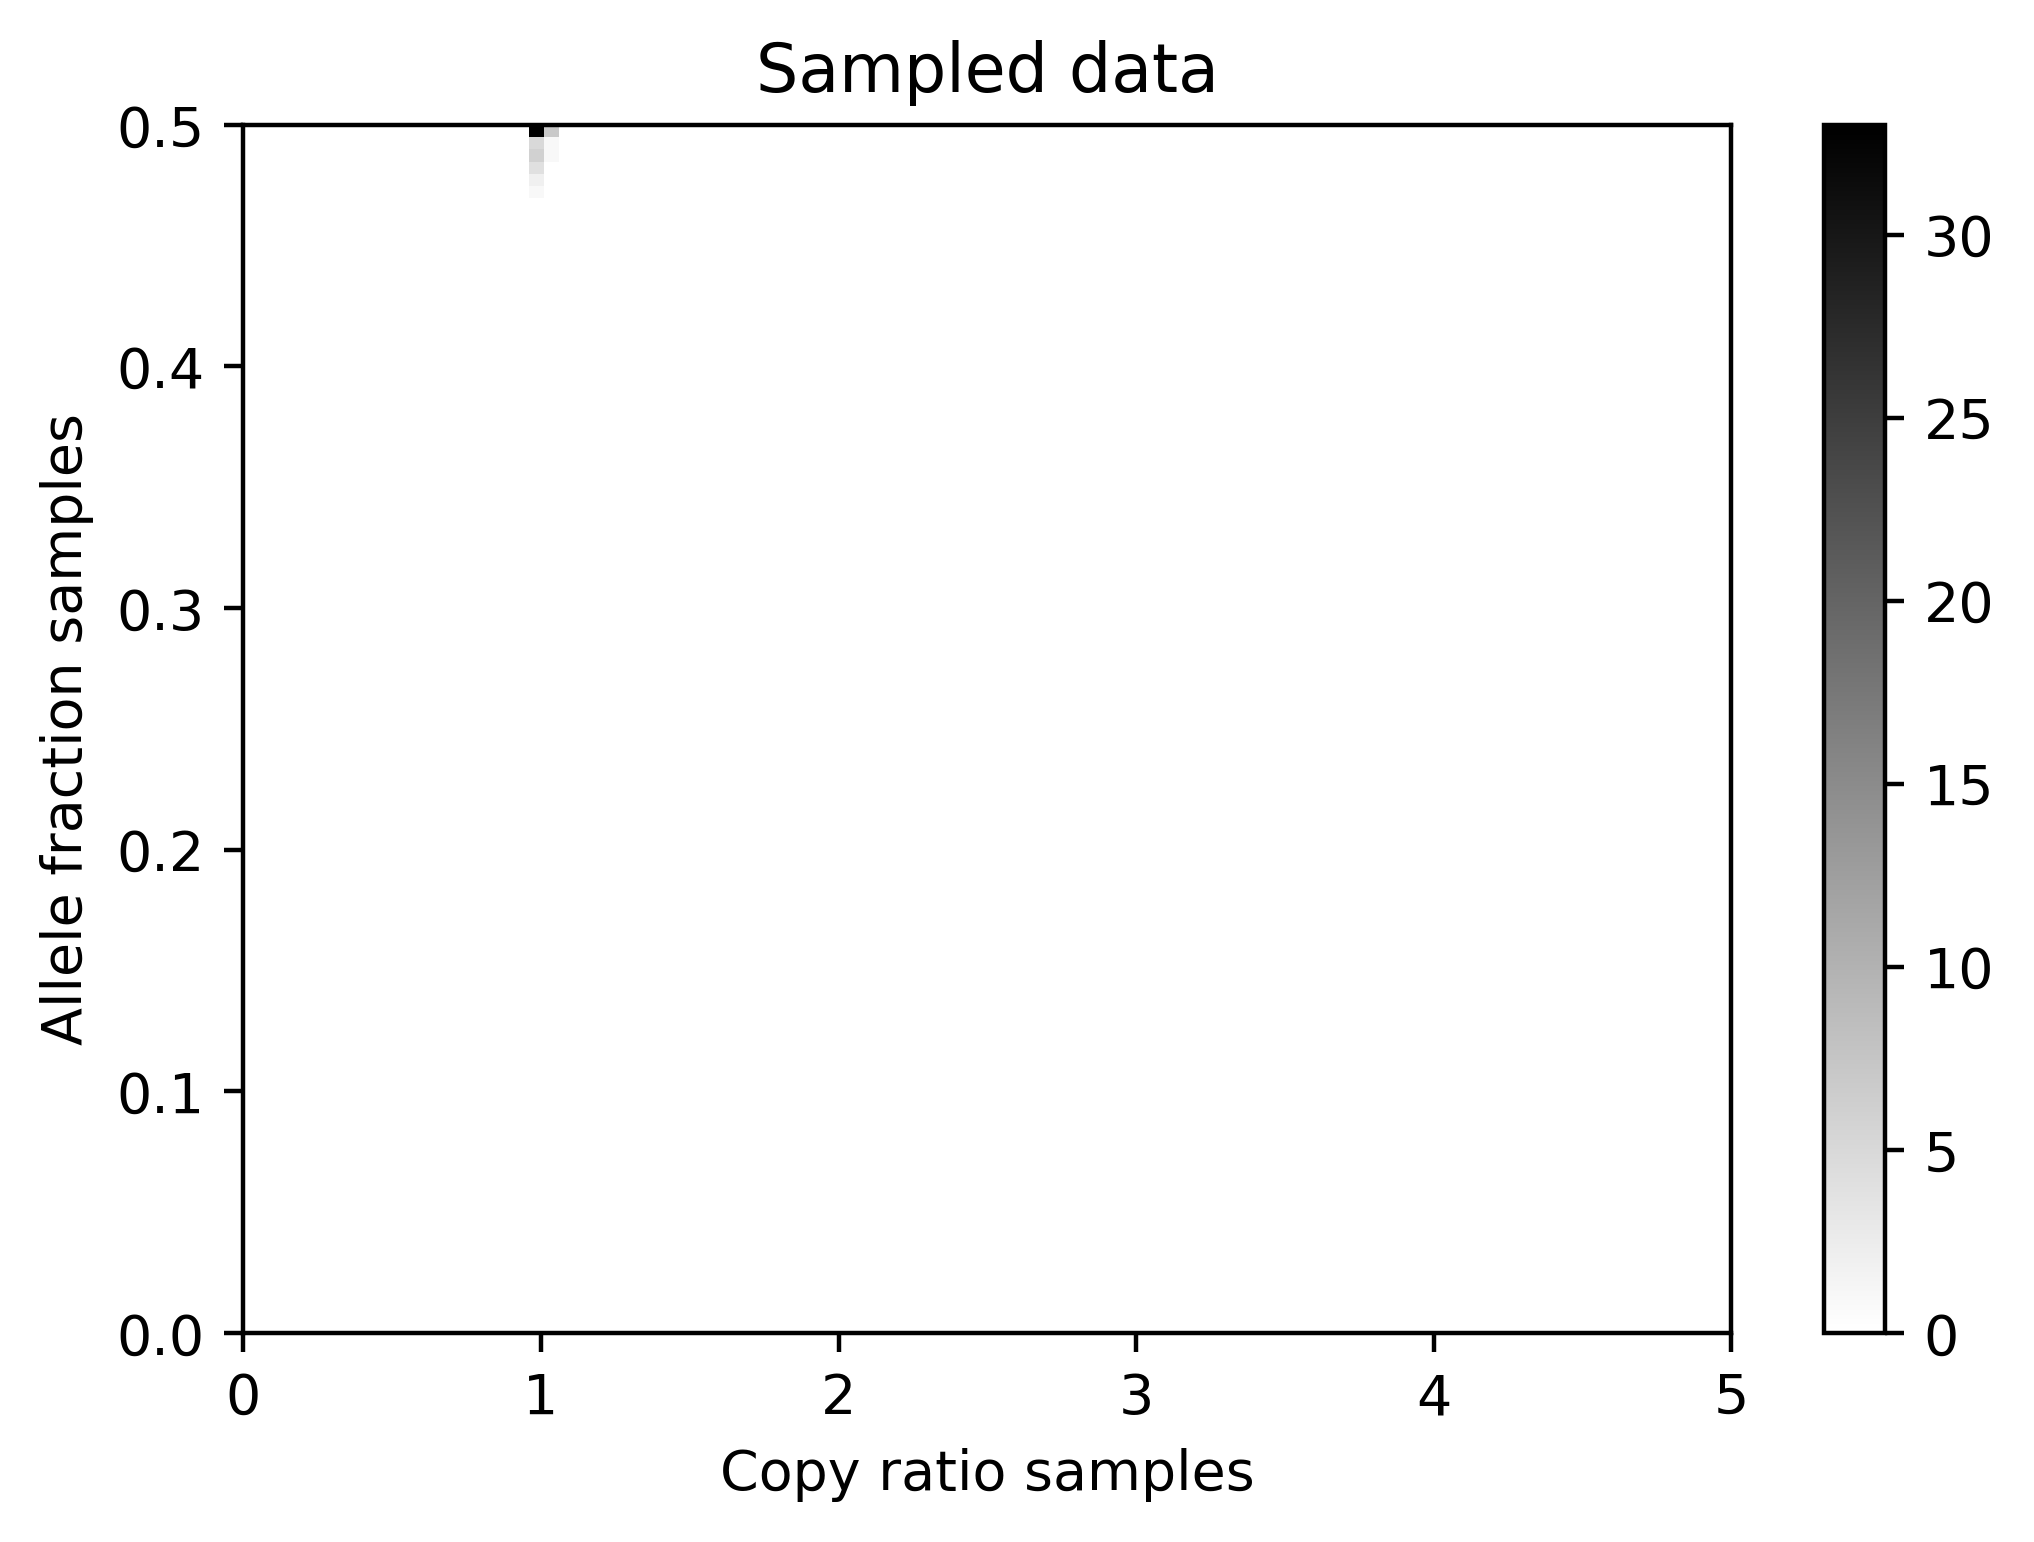

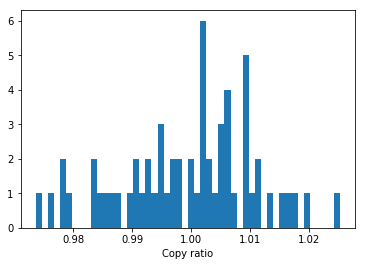

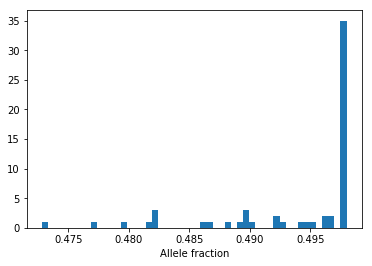

In [102]:
fname_data_file = "/Users/mkanaszn/Desktop/testing/normal_noisy_sample_data.seg" 
fname_truth_file = "/Users/mkanaszn/Desktop/testing/normal_noisy_sample_truth.seg"

purity=1.0
mother_father_prob = [[0, 0, 0], 
                      [0, 1, 0], 
                      [1, 1, 1],
                      [2, 0, 0],
                      [2, 1, 0],
                      [2, 2, 0],
                      [3, 0, 0],
                      [3, 1, 0],
                      [3, 2, 0],
                      [3, 3, 0]
                      ]

n_segments=60
average_segment_length=10000
average_coverage=7

sd_average=0.010
sd_sd=0.016

v = variant_probabilities(fname_data_file=fname_data_file,
                         fname_truth_file=fname_truth_file,
                         mother_father_prob=mother_father_prob,
                         purity=purity,
                         n_segments=n_segments,
                         average_segment_length=average_segment_length,
                         average_coverage=average_coverage,
                         sd_average=sd_average,
                         sd_sd = sd_sd
                         )

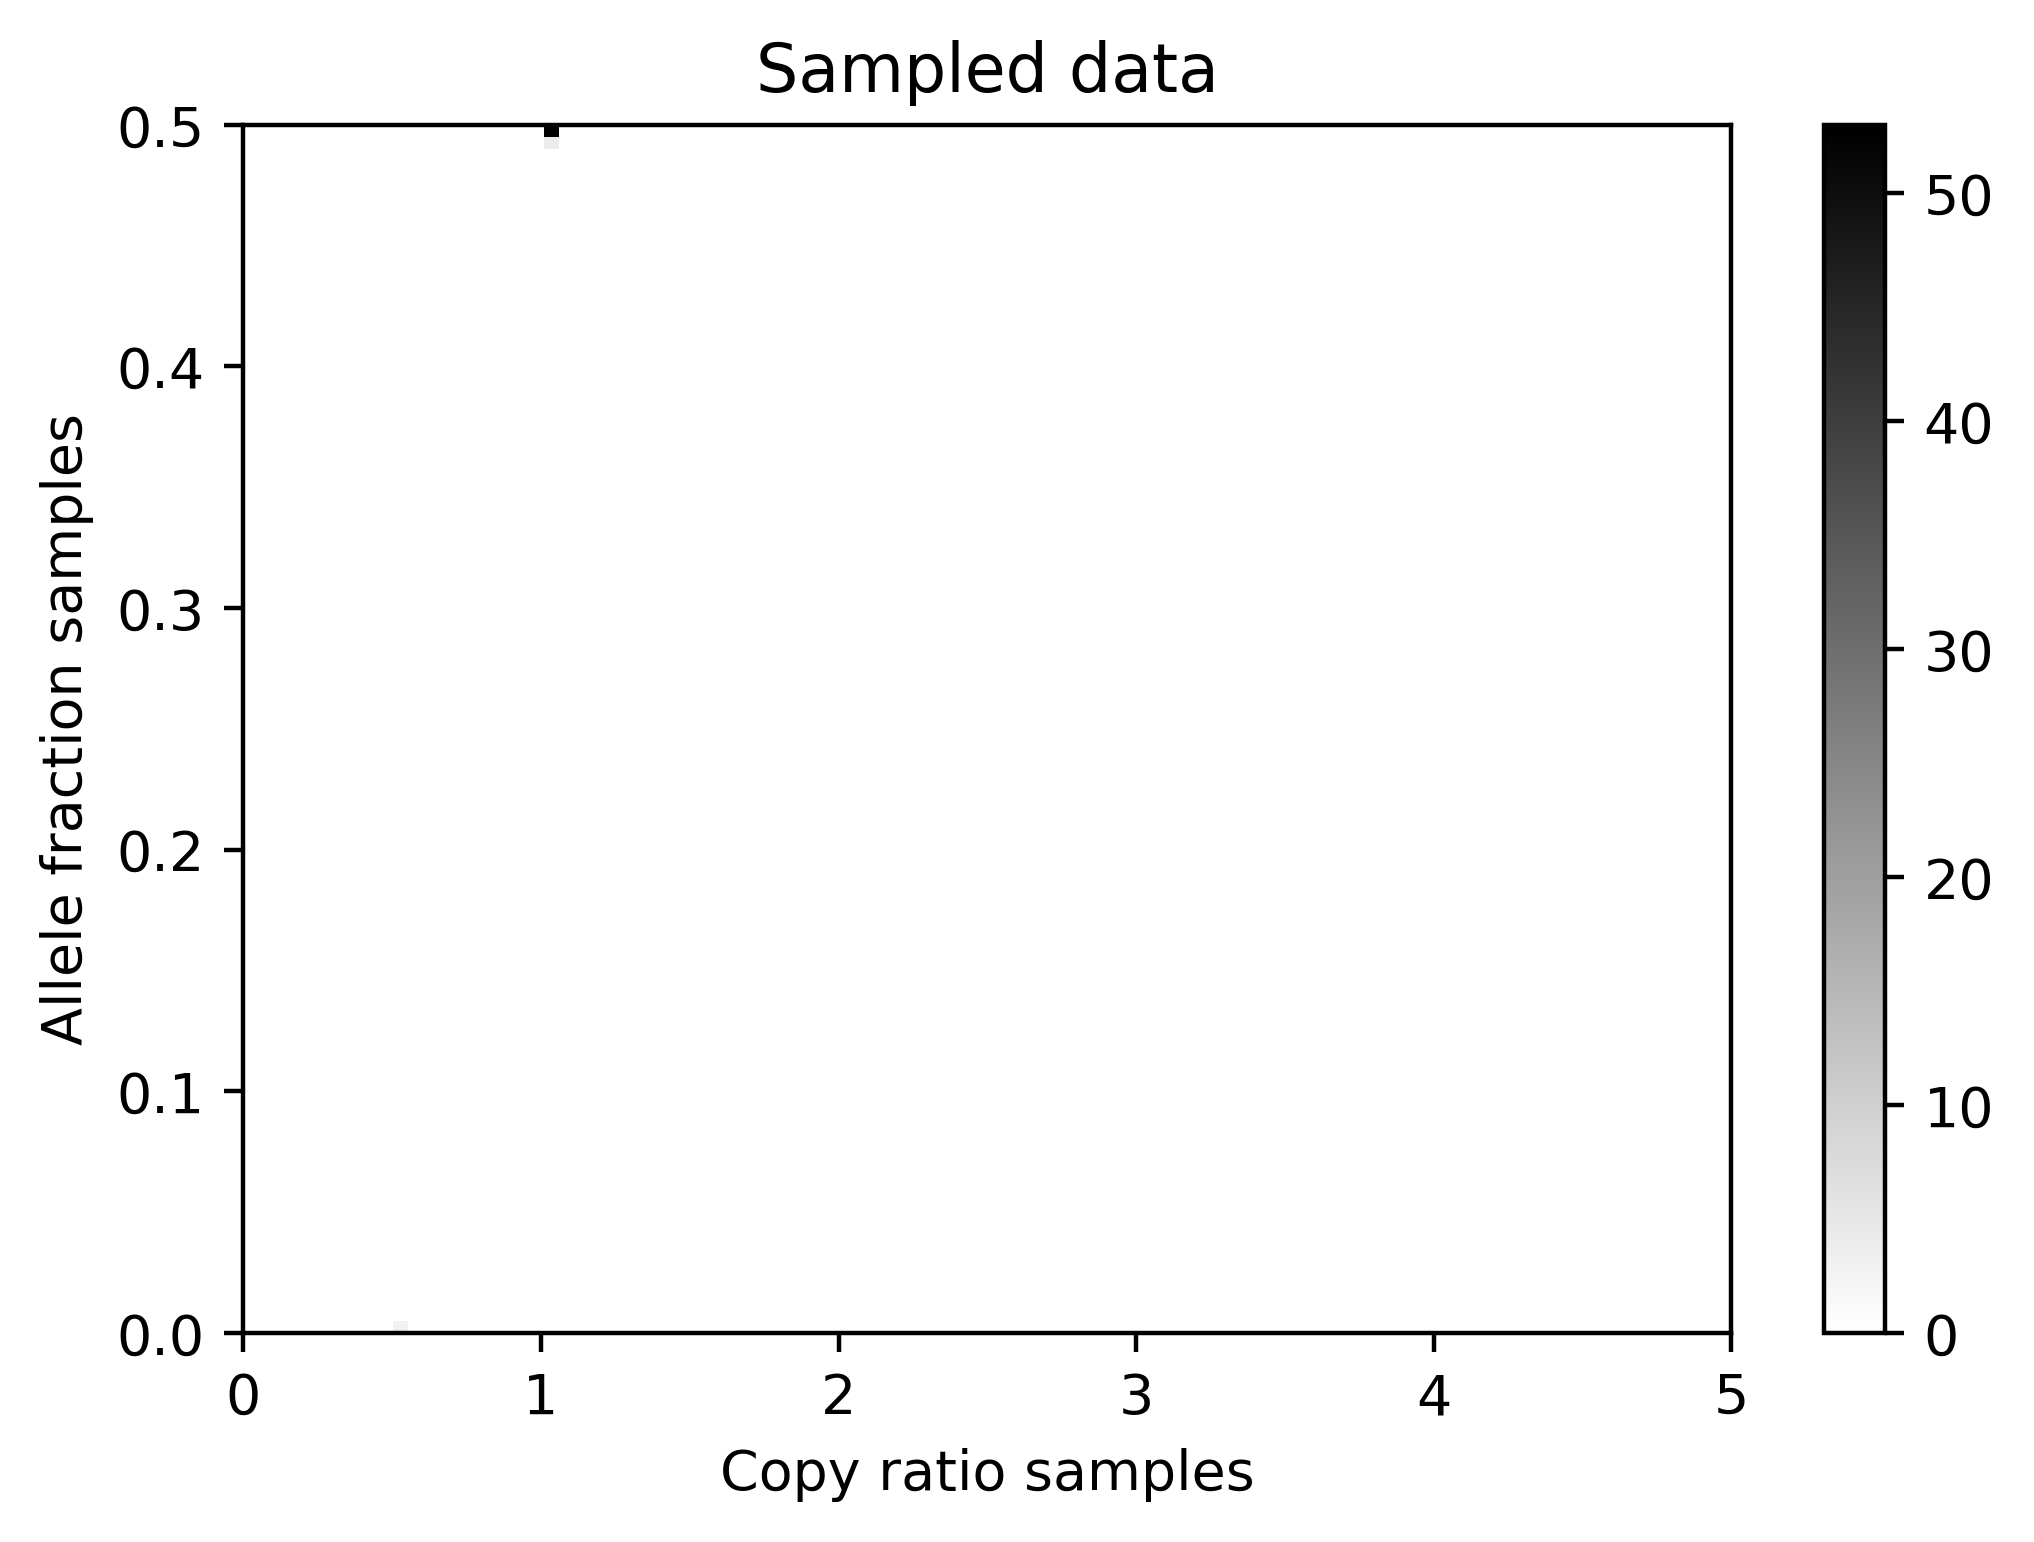

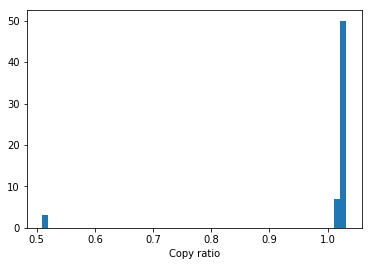

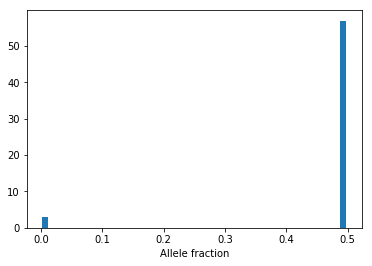

In [103]:
fname_data_file = "/Users/mkanaszn/Desktop/testing/normal_contaminated_data.seg" 
fname_truth_file = "/Users/mkanaszn/Desktop/testing/normal_contaminated_truth.seg"

purity=1.0
mother_father_prob = [[0, 0, 0], 
                      [0, 1, 0.04], 
                      [1, 1, 0.93],
                      [2, 0, 0],
                      [2, 1, 0.03],
                      [2, 2, 0],
                      [3, 0, 0],
                      [3, 1, 0],
                      [3, 2, 0],
                      [3, 3, 0]
                      ]

n_segments=60
average_segment_length=10000
average_coverage=7

sd_average=0.003
sd_sd=0.008

v = variant_probabilities(fname_data_file=fname_data_file,
                         fname_truth_file=fname_truth_file,
                         mother_father_prob=mother_father_prob,
                         purity=purity,
                         n_segments=n_segments,
                         average_segment_length=average_segment_length,
                         average_coverage=average_coverage,
                         sd_average=sd_average,
                         sd_sd = sd_sd
                         )